<a href="https://colab.research.google.com/github/BishoyAbd/CV-projec-v1_1/blob/CV-projec-v1_2/Cv-project-v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
! pip install -q kaggle
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

!pip install mtcnn


Saving kaggle.json to kaggle.json
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          10930        330  1.0              
zusmani/petrolgas-prices-worldwide                              Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33            601         55  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           6186        183  0.9705882        
ruchi798/data-science-job-

In [188]:
# !kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

In [189]:
!mkdir data
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d data

mkdir: cannot create directory ‘data’: File exists
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
replace data/example_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [190]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch as pt
import torchvision
import torch.nn as nn

from torchvision.datasets import KMNIST

from  torch.utils.data import random_split, DataLoader
import torchvision.transforms as trans
import torch.optim as optim

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import argparse
import pandas as pd
import time

from PIL import Image

import cv2 as cv
from mtcnn.mtcnn import MTCNN


#to resovle colab problem with cv.imshow()
from google.colab.patches import cv2_imshow as imshow
%matplotlib inline


# 1.Face detector

In [191]:
#get video from drive

#Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
!ls "drive/My Drive/cv project files/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
emos.mp4  EMOTION_DETECTOR_1.pt


In [240]:
from numpy.core.fromnumeric import size
fig = plt.figure(figsize=(9, 13))
# axis indices starting from 1
row=1
col=1
plot_idx=1
path="drive/My Drive/cv project files/emos2.mp4"

vcap = cv.VideoCapture(path)

FRAM_COUNT = vcap.get(cv.CAP_PROP_FRAME_COUNT)
FPS = int(vcap.get(cv.CAP_PROP_FPS))
STEP=5*FPS
current_time=0

# vcap.set(cv.CAP_PROP_POS_FRAMES, 100)
face_detector_model = MTCNN()
pos = 1
SIZE_TO_EM=(48,48)

arr_img= []
arr_time=[]
dic={}
while True:
    r, frame = vcap.read()
    if r:
      faces = face_detector_model.detect_faces(frame)
      vcap.set(cv.CAP_PROP_POS_FRAMES, pos)
      pos += STEP
      time_stamp=int(pos/FPS)
      # if time_stamp>20 :
      #   break
      if pos>=FRAM_COUNT-60:
        break
      for i, item in enumerate(faces):
          x,y,w,h = item['box']
          cv.rectangle(frame, (x, y),(x+w,y+h),  (0, 200, 120), 2)
          croped_image=frame[y:y+h, x:x+w]
          resized_image= cv.resize(croped_image, SIZE_TO_EM, interpolation = cv.INTER_AREA)
          arr_img.append(resized_image)
          arr_time.append(time_stamp)
          # ax=fig.add_subplot(8,4,plot_idx)
          # ax.set_title("time: {}".format(time_stamp))
          # fig.tight_layout()
          # plt.imshow(resized_image)
          # imshow(resized_image)
          plot_idx+=1
       
    if cv.waitKey(25) & 0xFF == ord("q"):
        break

vcap.release()
cv.destroyAllWindows()


<Figure size 648x936 with 0 Axes>

In [193]:
###################just for tests not used##################
train=pd.read_csv("/content/data/train.csv")
# test=pd.read_csv("/content/data/test.csv" )
# print(train['emotion'].unique())
# print(train['emotion'][1])
# train.head()

In [194]:
train[train['emotion']==6].count()

emotion    4965
pixels     4965
dtype: int64

In [195]:
# train['pixels']=train['pixels'].astype('string')
# img=np.fromstring(train['pixels'][0],np.float32 ,sep=' ')
# plt.imshow(img.reshape(48,48))

In [196]:
class FaceDataSet(pt.utils.data.Dataset):

  def __init__(self,csv_file,transform=None):
    self.data=pd.read_csv(csv_file)
    # convert obj col to string
    self.data['pixels']= self.data['pixels'].astype('string')
    self.data=self.data[(self.data['emotion']==3 )| (self.data['emotion']==4) | (self.data['emotion']==6 ) ].reset_index()
    self.data['emotion'].replace({3:0,4:1,6:2}, inplace=True)
    self.data.drop('index', inplace=True, axis=1)
    self.transform=transform
    
  def __len__ (self,):
    return len(self.data['pixels'])
    

  def __getitem__(self,idx):
    item=np.fromstring(self.data['pixels'][idx], sep=' ').reshape(48,48)/255
    y=self.data['emotion'][idx]

    if self.transform:
      item=self.transform(item)

    return item,y




In [197]:
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
# device="cpu"

In [198]:
from torchvision.transforms.transforms import RandomRotation
transforms=trans.Compose([trans.ToTensor()])

train_ds=FaceDataSet("/content/data/train.csv", transforms)
# test_ds=FaceDataSet("/content/data/test.csv", transforms)

BATCH_SIZE=32
lr=.001
batch_size=64
epochs =10

train_split=.75
valid_split=1-train_split


num_train = int(len(train_ds) * train_split) + 1
num_valid = int(len(train_ds) * valid_split)

train_ds,valid_ds=pt.utils.data.random_split(train_ds,[num_train ,num_valid], generator=pt.Generator().manual_seed(40))
train_loader=pt.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=pt.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE)
# test_loader=pt.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE)


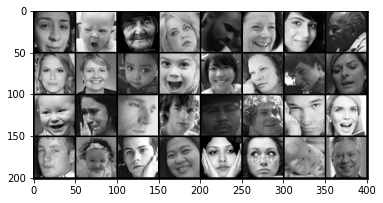

In [199]:
sample=next(iter(train_loader))
imgs,labels=sample
images= torchvision.utils.make_grid(imgs)
plt.imshow(np.transpose(images, (1,2,0)))
#  (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

# 1. Model 

In [215]:
class EmotionDetector(nn.Module):
  def __init__(self, in_ch,classes):
    super(EmotionDetector,self).__init__()

    self.conv1=nn.Conv2d(in_channels=in_ch,out_channels=60, kernel_size=(3,3))
    self.relu1=nn.ReLU()
    self.bn1=nn.BatchNorm2d(60)
    self.maxPool1=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))


    self.conv2=nn.Conv2d(in_channels=60,out_channels=120, kernel_size=(3,3))
    self.relu2=nn.ReLU()
    self.bn2=nn.BatchNorm2d(120)
    self.maxPool2=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))


    self.conv3=nn.Conv2d(in_channels=120,out_channels=240, kernel_size=(3,3))
    self.relu3=nn.ReLU()
    self.bn3=nn.BatchNorm2d(240)
    # self.maxPool3=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    #28*28*1 -> 27-13-> 12-6 *80 -> 5*4*100
    #    
    self.dropout=nn.Dropout2d()

    self.conv4=nn.Conv2d(in_channels=240,out_channels=480, kernel_size=(3,3))
    self.relu4=nn.ReLU()
    self.maxPool4=nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))



    # self.conv5=nn.Conv2d(in_channels=120,out_channels=150, kernel_size=(5,5))
    # self.relu5=nn.ReLU()
    # self.maxPool5=nn.MaxPool2d(kernel_size=(2,2), stride=(1,1))


    self.fc1=nn.Linear(in_features=480*3*3,out_features=200)
    self.relu_fc1=nn.ReLU()

    self.fc2=nn.Linear(in_features=200,out_features=classes)
    self.lsm=nn.LogSoftmax(dim=1)

  def forward(self,x):
    debug=False
    x=x.float()
    if debug : print("input to cv1 ",x.shape)
    x=self.conv1(x)
    if debug : print("input to mxp1",x.shape)
    x=self.bn1(x)
    x=self.relu1(x)
    x=self.maxPool1(x)
    # x=self.dropout(x)


    if debug :print("input to cv2",x.shape)
    x=self.conv2(x)
    x=self.bn2(x)

    if debug : print("input to mxp2",x.shape)
    x=self.relu2(x)
    x=self.maxPool2(x)
    # x=self.dropout(x)

    if debug : print("input to cv3",x.shape)
    x=self.conv3(x)
    x=self.bn3(x)
    x=self.relu3(x)
    if debug : print("input to mxp3",x.shape)
    # x=self.maxPool3(x)
    x=self.dropout(x)

    
    x=self.conv4(x)
    x=self.relu4(x)
    x=self.maxPool4(x)
    x=self.dropout(x)
    # x=self.conv5(x)
    # x=self.relu5(x)
    # x=self.maxPool5(x)

    if debug : print("input to fc1",x.shape)
    x = pt.flatten(x,1)
    
    x=self.fc1(x)
    x=self.relu_fc1(x)
    if debug : print("input to fc2 ",x.shape)
    x=self.fc2(x)
    if debug : print("input to lsm ",x.shape)
    output=self.lsm(x)
    if debug : print("final output ",x.shape)
    return output

# 2. Train the Model

## load and transfrom data

In [216]:
train_steps = len(train_loader.dataset) // batch_size
valid_steps = len(valid_loader.dataset) // batch_size
print ("train is {}\nvalidation is {}".format(train_steps,valid_steps))

train is 199
validation is 66


In [217]:
CLASSES=3
model=EmotionDetector(in_ch=1,classes=CLASSES).to(device)

optimizer=optim.Adam(model.parameters(),lr=lr)

loss_fn=nn.NLLLoss()

obervations = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}


In [218]:
# train 
for ep in range(0, 10):
  
  model.train()

  total_train_loss=0
  total_valid_loss=0

  train_correct=0
  valid_correct=0

  for (x,y) in train_loader:
    
    x,y= (x.to(device), y.to(device) )
    
    pred= model(x)
    loss=loss_fn(pred,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_train_loss+=loss.item()

    train_correct+= (pred.argmax(1)==y).type(pt.float).sum().item()


  with pt.no_grad():
      model.eval()

      for (x,y) in valid_loader:
         x,y= (x.to(device), y.to(device) )
         
         pred=model(x)
         total_valid_loss+=loss_fn(pred,y)

         valid_correct+= (pred.argmax(1)==y).type(pt.float).sum().item()

  avg_train_loss=total_train_loss/train_steps
  avg_valid_loss= total_valid_loss/valid_steps

  train_correct=train_correct/len(train_loader.dataset)
  valid_correct=valid_correct/len(valid_loader.dataset)


  # update our training history
  obervations["train_loss"].append(avg_train_loss)
  obervations["train_acc"].append(train_correct)
  obervations["val_loss"].append(avg_valid_loss)
  obervations["val_acc"].append(valid_correct)
  # print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(ep + 1, epochs))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
  print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format( avg_valid_loss, valid_correct))  

[INFO] EPOCH: 1/10
Train loss: 1.847581, Train accuracy: 0.5429
Val loss: 1.636423, Val accuracy: 0.6308

[INFO] EPOCH: 2/10
Train loss: 1.532091, Train accuracy: 0.6413
Val loss: 1.470672, Val accuracy: 0.6646

[INFO] EPOCH: 3/10
Train loss: 1.441055, Train accuracy: 0.6666
Val loss: 1.428296, Val accuracy: 0.6550

[INFO] EPOCH: 4/10
Train loss: 1.368999, Train accuracy: 0.6916
Val loss: 1.332532, Val accuracy: 0.7025

[INFO] EPOCH: 5/10
Train loss: 1.319304, Train accuracy: 0.7066
Val loss: 1.341021, Val accuracy: 0.7100

[INFO] EPOCH: 6/10
Train loss: 1.274368, Train accuracy: 0.7178
Val loss: 1.296818, Val accuracy: 0.7152

[INFO] EPOCH: 7/10
Train loss: 1.233931, Train accuracy: 0.7282
Val loss: 1.294475, Val accuracy: 0.7143

[INFO] EPOCH: 8/10
Train loss: 1.190815, Train accuracy: 0.7402
Val loss: 1.273893, Val accuracy: 0.7241

[INFO] EPOCH: 9/10
Train loss: 1.156225, Train accuracy: 0.7471
Val loss: 1.268499, Val accuracy: 0.7138

[INFO] EPOCH: 10/10
Train loss: 1.126735, Trai

In [219]:
MODEL_NAME= 'EMOTION_DETECTOR_1.pt'
MODEL_PATH = f"drive/My Drive/cv project files//{MODEL_NAME}" 


In [223]:
pt.save(model.state_dict(), MODEL_PATH)

## prediction Second part (Emotions detection model)

In [213]:
model=EmotionDetector(in_ch=1,classes=CLASSES).to(device)
model.load_state_dict(pt.load(MODEL_PATH))

<All keys matched successfully>

In [229]:
image2 = Image.fromarray(np.uint8(arr_img[0])).convert('L')
img = trans.ToTensor()(image2).type(pt.FloatTensor).to("cuda").reshape(1,1,48,48)
pred = model(img)


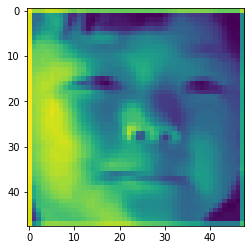

In [230]:
image2 = Image.fromarray(np.uint8(arr_img[11])).convert('L')
img = trans.ToTensor()(image2).type(pt.FloatTensor).to("cuda").reshape(1,48,48)
plt.imshow(img.cpu().numpy()[0])

In [241]:
output_emo=[]
model.eval()
with pt.no_grad():
  for image, time in zip(arr_img,arr_time):
      image2 = Image.fromarray(np.uint8(image)).convert('L')
      img = trans.ToTensor()(image2).type(pt.FloatTensor).to("cuda").reshape(1,1,48,48)
      pred=pt.exp(model(img))
    
      idx=pred.argmax(axis=1).cpu().numpy()[0]
      output_emo.append(idx)

In [242]:
for em, t in zip(output_emo,arr_time):
  print("{} : {}\n".format(em,t))

2 : 15

2 : 35

0 : 50

1 : 50

0 : 60

2 : 60

1 : 60

0 : 60

1 : 60

1 : 60

0 : 65

1 : 75

1 : 85

0 : 90

1 : 90

1 : 105

0 : 115

0 : 135

0 : 160

0 : 185

2 : 190

0 : 235

0 : 240

0 : 245

0 : 250

1 : 250

1 : 255

0 : 270

1 : 270

1 : 285

0 : 300

0 : 310

1 : 310

2 : 315

2 : 325

1 : 335

0 : 335

2 : 355

0 : 370

0 : 380

0 : 385

1 : 385

0 : 390

2 : 410

